## Regime Transiente 2D Difusão de Calor

Equação 2D:

$$\frac{\partial^2 T}{\partial^2 x}  + \frac{\partial^2 T}{\partial^2 y} = \alpha^2 \frac{\partial T}{\partial t}  \tag{1}$$

Onde difusividade térmica é:

$$ \alpha^2 = \frac{k}{\rho c} $$ em $ \frac{m^2}{s} $

Em um grid regular, utilizando discretização em diferenças finitas usando diferenças centradas para o espaço:

O indice de tempo é **n** e indice do eixo x é **i** e no eixo y é **j**.  

$$
\frac{\partial^2 T^n_{ij}}{\partial^2 x}  = \frac{T_{i+1j}^n-2T_{ij}^n+T_{i-1j}^n}{\Delta x^2}  
\tag{2}
$$

$$
\frac{\partial^2 T^n_{ij}}{\partial^2 y}  = \frac{T_{ij+1}^n-2T_{ij}^n+T_{ij-1}^n}{\Delta y^2}  
\tag{3}
$$

e diferença progressiva para o tempo nos indices de tempo **n** e **n+1** ("futuro"):

$$ \frac{\partial T_{ij}^n}{\partial t} = \frac{T_{ij}^{n+1}-T_{ij}^n}{\Delta t} \tag{4} $$






Combinando as equações (2), (3) e (4) chegamos em um esquema de "marcha" em (5).  
Onde os valores **n+1** ("futuro") podem ser calculados a partir dos valores em **n**: 

$$ \frac{T_{ij}^{n+1}-T_{ij}^n}{\Delta t} \alpha^2  = \frac{T_{i+1j}^n-2T_{ij}^n+T_{i-1j}^n}{\Delta x^2} + \frac{T_{ij+1}^n-2T_{ij}^n+T_{ij-1}^n}{\Delta y^2}$$


Considerando $\Delta x = \Delta y = \Delta s$

$$ T_{ij}^{n+1} = \frac{1}{\alpha^2 } \frac{\Delta t}{\Delta s^2}\left(T_{i+1j}^n-2T_{ij}^n+T_{i-1j}^n+T_{ij+1}^n-2T_{ij}^n+T_{ij-1}^n\right)  + T_{ij}^n $$

$$ T_{ij}^{n+1} = \lambda \left(T_{i+1j}^n+T_{i-1j}^n+T_{ij+1}^n+T_{ij-1}^n-4T_{ij}^n\right)  + T_{ij}^n \tag{5}$$

onde:

$$ \lambda = \frac{1}{\alpha^2 } \frac{\Delta t}{\Delta s^2} \tag{6} $$ 

Para garantir estabilidade numérica do esquema conforme orientação $\lambda \leq 2$

A equação (5) pode ser escrita como uma convolução. 
Sendo o operador de diferenciação na direção x e y substituido pelo kernel : 

$$
\begin{vmatrix} 
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0 
\end{vmatrix}
$$

$$
T_{ij}^{n+1} = \lambda \ \ T_{ij}^n  \circledast 
\begin{vmatrix} 
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0 
\end{vmatrix} 
 + T_{ij}^n 
$$

  
Nota .: A convolução deve ser somente para região de "sobreposição" (overlap) completo. (numpy 'valid' mode)

In [3]:
#%load_ext Cython

In [3]:
import numpy as np

In [8]:
k = np.zeros((4,4))
k[:,-1] = 1
k[:, 1:-1]
N=6
tplaca = np.zeros((N, N)) # temperatura da placa em tn e tn+1 : 
# condições de contorno iniciais no tempo 0 
# extremidades da placa 
tplaca[:,  0] = 100. # esquerda 
tplaca[:, -1] = 50. # direita
kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]]) # diferenciador convolucional    

In [26]:
tplaca

array([[ 100.,    0.,    0.,    0.,    0.,   50.],
       [ 100.,    0.,    0.,    0.,    0.,   50.],
       [ 100.,    0.,    0.,    0.,    0.,   50.],
       [ 100.,    0.,    0.,    0.,    0.,   50.],
       [ 100.,    0.,    0.,    0.,    0.,   50.],
       [ 100.,    0.,    0.,    0.,    0.,   50.]])

In [38]:
tplaca.shape

(6, 6)

### Condições de contorno da direção y topo e base
Não foram especificadas no enunciado do exerício assim assumindo como = 0.

In [40]:
#%%cython
import numpy as np
from scipy.signal import fftconvolve

#import cython

#@cython.boundscheck(False)
#@cython.wraparound(False)
def rodarSimulacao(N, duracao, save=10, lmbda=0.04175):
    """
    * N : numero de pontos discretização em x e y
    * duracao : em segundos da simulacao da difusao
    * lmbda : lambda predefido para garantir estabilidade numérica 
    igual à 0.04175 baseado no item 1
    * save : numero de 'snapshots' para salvar  
    
    O numero de iteracoes é calculado baseado na duracao
    """
    k = 0.835 #K alumínio = 1/alfa^2
    ds = 10./(N-1) # 10 cm / N-1 pontos discretização espaço 
    dt = (ds**2*lmbda)/k # discretização tempo garantindo lambda igual à 0.04175
    lmbda = (k*dt)/ds 
    # "paineis" com temperatura da placa em tn e tn+1
    # 1 painel só não são necessários dois já que tn+1 = f(tn)
    tplaca = np.zeros((N, N)) # temperatura da placa em tn e tn+1 : 
    # condições de contorno iniciais no tempo 0 
    # extremidades da placa 
    tplaca[:,  0] = 100. # esquerda 
    tplaca[:, -1] = 50. # direita
    # topo e base da placa assumindo temperatura = 0
    # na ausência de definição do enunciado
    kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]]) # diferenciador convolucional    
    niter = int(duracao/dt) # numero de iteracoes necessarias para essa duracao
    nsave = int(niter/save) # step de iteracoes para salvar 'snapshot'
    snapshots = np.zeros((save+1, N, N)) # 'filme' das iteracoes
    isnap = 0 # indice para salvar 'snapshots' das iteracoes        
    
    for n in range(niter): # marcha
        # calcula tn+1 em funcao de f(tn) 
        tplaca[1:-1, 1:-1] = lmbda*(fftconvolve(kernel, tplaca, mode='valid')) + tplaca[1:-1, 1:-1] 
        if n%nsave==0:
            snapshots[isnap] = tplaca
            isnap += 1 # p/ próximo 'frame' do 'filme'
    
    # imprime um resumo de alguns parâmetros
    print('Dt: {:.3g} numero de Iteracoes: {:5d} '.format(dt, niter))
    
    # salva o último
    snapshots[-1] = tplaca
    # retorna o 'filme' de snapshots, e o intervalo em x
    
    return snapshots, ds

In [43]:
%matplotlib inline
from matplotlib import pyplot as plt

In [76]:
%%time
# solucao para 300 segundos de difusao, 101 pontos e 5 snapshots
snapshots, dx = rodarSimulacao(31, 3., save=5)

Dt: 0.00556 numero de Iteracoes:   540 
Wall time: 118 ms


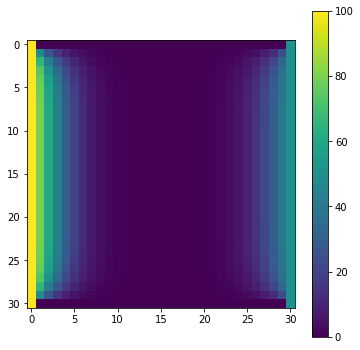

In [80]:
# tamanho da figura dimensões em polegadas
plt.figure(figsize=(6,6))
# a cada algumas iterações plota a temperatura da barra
plt.imshow(snapshots[5])
# plota legenda
plt.colorbar()

In [67]:
snapshots[:,3,:].shape

(6, 10)

Snapshots posição y=3

Dt: 0.2 numero de Iteracoes:    50 
Wall time: 47 ms


C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


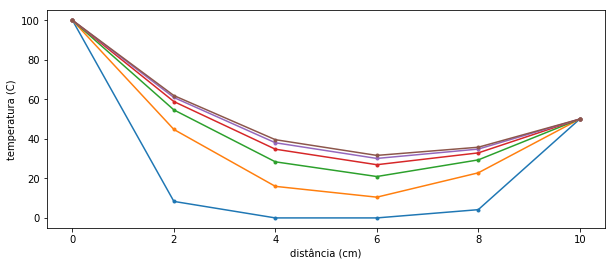

In [68]:
%%time
# solucao para 300 segundos de difusao, 101 pontos e 5 snapshots
snapshots, dx = rodarSimulacao(6, 10., save=5)
# tamanho da figura dimensões em polegadas
plt.figure(figsize=(10,4))
# a cada algumas iterações plota a temperatura da barra
# posição y = 3
plt.plot(np.arange(6)*dx, snapshots[:,3,:].T, '.-')
plt.ylabel('temperatura (C)')
plt.xlabel('distância (cm)')

# plota legenda
plt.legend()

_________________________________________________________

_________________________________________________________

_________________________________________________________

# 3.
Compare os erros das solucoes numericas de equilıbrio (nos 2 casos anteriores) em relacao a solu¸cao analıtica  
(uma reta que passa pelos pontos de temperatura 100◦e 50◦C nos extremos), em especial no caso de utilizacao  
de λ = 1/6 (que tende a minimizar os erros);  

A solução analítica pode ser escrita como uma reta:

$$ f(x) = 100 -5x $$ 

Lembrando que a barra tem 10 cm e logo que $\Delta x = \frac{10}{N-1} $.  
Escrevendo em função dos **N** pontos de discretização e $ \Delta x $


$$ f(i\Delta x) = 100 -5(i\Delta x) $$
$$ f(i) = 100 -5(i\Delta x) $$

Onde $i$ represente um indíce de posição na barra.